In [1]:
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import GroupShuffleSplit

### Feature eng

In [2]:
def read_file(path):
    """
    reads the file in pandas df and converts the date_time column to datetime type
    """
    df = pd.read_csv(path)
    df['date_time'] = pd.to_datetime(df['date_time'])
    return df

def sample_on_srch_id(df, frac = 0.1):
    """
    samples the dataframe based on the fraction of srach_id
    """
    # get unique srch_ids
    srch_ids = np.unique(df.srch_id)
    # calculate how many ids to return
    chosen_k = int(len(srch_ids) * frac)
    # sample ids
    chosen_ids = random.sample(list(srch_ids), k = chosen_k)
    # filter the df to only have sampled ids
    return df[df['srch_id'].isin(chosen_ids)]

### Feature Engineering --------------------------

## missing data ----------------------------------

def remove_missing_values(df):
    """
    removes columns with more than 50 percent missing data
    """
    missing_values = df.isna().mean().round(4) * 100
    missing_values = pd.DataFrame(missing_values).reset_index()
    missing_values.columns = ["column", "missing"]
    # filter where there are missing values
    missing_values.query("missing > 50", inplace=True)  # remove columns with more than 50 % of missing values
    missing_values.sort_values("missing", inplace=True)
    #print(missing_values)
    df.drop(missing_values.column, axis=1, inplace=True)

def replace_missing_values(df):
    """
    imputes missing values with -1
    """
    df.fillna(value=-1, inplace=True) 

## new features ----------------------------------

def extract_time(df):
    """ 
    month, week, day of the week and hour of search
    """
    df_datetime = pd.DatetimeIndex(df.date_time)
    df["month"] = df_datetime.month
    df["week"] = df_datetime.week
    df["day"] = df_datetime.dayofweek + 1
    df["hour"] = df_datetime.hour
    del df['date_time']

def new_historical_price(df):
    """
    'unlogs' prop_log_historical_price column
    """
    df["prop_historical_price"] = (np.e ** df.prop_log_historical_price).replace(1.0, 0)
    df.drop("prop_log_historical_price", axis=1, inplace=True)

def add_price_position(df, rank_type = "dense"):
    """
    adds hotel price position ("price_position") inside "srch_id" column
    """
    ranks = df.groupby('srch_id')['price_usd'].rank(ascending=True, method = rank_type)
    df["price_position"] = ranks


def average_numerical_features(df, group_by = ["prop_id"], columns = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2"]):
    """
    adds mean, median and standard deviation per prop_id (default) 
    for columns that are related to property (default)
    """
    # caulcate means and rename columns
    means = df.groupby(group_by)[columns].mean().reset_index()
    means.columns = [means.columns[0]] + [x + "_mean" for x in means.columns[1:]]
    # caulcate median and rename columns
    medians = df.groupby(group_by)[columns].median().reset_index()
    medians.columns = [medians.columns[0]] + [x + "_median" for x in medians.columns[1:]]
    # caulcate means and rename columns
    stds = df.groupby(group_by)[columns].std().reset_index()
    stds.columns = [stds.columns[0]] + [x + "_std" for x in stds.columns[1:]]
    ## attach aggregated data to the df
    df = pd.merge(df, means, on=group_by)
    df = pd.merge(df, medians, on=group_by)
    df = pd.merge(df, stds, on=group_by)
    return df

def add_historical_booking_click(df):
    """
    creates a column with the percentage of the prop_id booked/clicked rate overall
    """
    # there are more prop_id in the test data than in train. 
    # Maybe we could still use this but would need to impute
    # with the most common value (or something else)
    
    historical = df.groupby("prop_id")[["click_bool", "booking_bool"]].mean().reset_index()
    historical.columns = [historical.columns[0]] + [x + "_rate" for x in historical.columns[1:]]
    df = pd.merge(df, historical, on="prop_id")
    df.sort_values("srch_id", inplace = True)
    return df

def join_historical_data(df, path = "hist_click_book.csv"):
    """
    joins historical data according to prop_id. 
    path - location of historical data csv file
    
    """
    to_join = pd.read_csv(path)
    joined = pd.merge(df, to_join, on="prop_id")
    return joined.sort_values("srch_id")

def create_comp_rate_mode(df, fillna_ = -100):
    """
    creates a column with the mode of comp_rate columns and fills the rest with -100 (default)
    """
    #subset comp_rate
    comp_rate_cols = [col for col in df.columns if col.endswith("_rate")]
    df["comp_rate_mode"] = df[comp_rate_cols].mode(axis = 1, dropna = True)[0]
    df["comp_rate_mode"].fillna(fillna_ , inplace = True)

def create_comp_inv_mode(df, fillna_ = -100):
    """
    creates a column with the mode of comp_inv columns and fills the rest with -100 (default)
    """
    comp_inv = [col for col in df.columns if col.endswith("_inv")]
    df["comp_inv_mode"] = df[comp_inv].mode(axis = 1, dropna = True)[0]
    df["comp_inv_mode"].fillna(fillna_ , inplace = True)

def create_comp_rate_precent_mean(df, fillna_ = -100):
    """
    creates a column with the mean of comp_rate_precent columns and fills the rest with -100 (default)
    """
    comp_rate_precent = [col for col in df.columns if col.endswith("_rate_percent_diff")]
    df["comp_rate_precent_mean"] = df[comp_rate_precent].mean(axis = 1, dropna = True)[0]
    #df["comp_rate_precent_mean"].fillna(fillna_ , inplace = True)  

def normalize_features(df_mod, normalizing_var, column):
    # df_mod = dataframe
    # normalizing_var = variable that will be used for normalizing
    # column = variable that will be normalized

    methods = ["mean", "std"]

    df = df_mod.groupby(normalizing_var).agg({column: methods})

    df.columns = df.columns.droplevel()
    col = {}
    for method in methods:
        col[method] = column + "_" + method

    df.rename(columns=col, inplace=True)
    df_merge = df_mod.merge(df.reset_index(), on=normalizing_var)
    df_merge[column + "_norm_by_" + normalizing_var] = (
        df_merge[column] - df_merge[column + "_mean"]
    ) / df_merge[column + "_std"]
    df_merge = df_merge.drop(labels=[col["mean"], col["std"]], axis=1)

    return df_merge   

def add_normalisation(df, target_list = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2"]):
    for column in target_list:
        df = normalize_features(df, normalizing_var="srch_id", column=column)
    return df 
    
## other ----------------------------------

def remove_cols(df, cols = ["position", "prop_id"]):
    df.drop(cols, axis=1, inplace=True)

def remove_positions(df, positions = [5, 11, 17, 23]):
    """
    removes hotels with specified positions 
    (based on the fact that hotels in those positions were not as booked)
    """
    df = df[df["position"].isin(positions) == False]

def add_score(df):
    """
    adds 'score' column to the df: 5 for booked, 1 for clicked
    """
    score = []
    for book, click in zip(df.booking_bool, df.click_bool):
        if book == 1:
            score.append(5)
            continue
        if click == 1:
            score.append(1)
            continue
        else:
            score.append(0)
    df["score"] = score
    del df['booking_bool']
    del df['click_bool']

def onehot(df, cols):
    """ 
    returns a df with one-hot encoded columns (cols)
    """
    
    return pd.get_dummies(df, columns=cols)


### Feature engineering function -----------

def feature_engineering_train(df):
    
    extract_time(df)
    create_comp_rate_mode(df)
    create_comp_inv_mode(df)
    remove_missing_values(df)
    replace_missing_values(df)
    new_historical_price(df)
    add_price_position(df)
    #df = average_numerical_features(df)
    #df = add_historical_booking_click(df)
    df = add_normalisation(df)
    add_score(df)
    #remove_cols(df)
    return df


def feature_engineering_test(df):
    
    extract_time(df)
    create_comp_rate_mode(df)
    create_comp_inv_mode(df)
    remove_missing_values(df)
    replace_missing_values(df)
    new_historical_price(df)
    add_price_position(df)
    #df = average_numerical_features(df)
    df = add_normalisation(df)
    return df
    

In [3]:
def NDCG(predictions, df, path_idcg = "idcg.csv"):
    """
    takes predicted positions and calulates average ndcg.
    predictions - dataframe must have "srch_id" and "prop_id" ordered by relevance (inside "srch_id") (basically Lotte's model "out" dataframe)
    df - training dataset (must contain "srch_id", "prop_id", "score")
    path_idcg - path to idcg scores per "srch_id"
    """
    # reset index 
    predictions.reset_index(drop = True, inplace = True)
    # add position + 1
    predictions["position"] = predictions.groupby(by = ['srch_id']).cumcount()+1
    # filter to only have positions up to 5
    predictions = predictions[predictions.position < 6]
    # attach scores to predictions
    predictions = pd.merge(predictions, df[["srch_id", "prop_id", "score"]], on = ["srch_id", "prop_id"])
    predictions["numerator"] = predictions["score"]
    predictions["denominator"] = np.log2(predictions["position"])
    predictions.loc[predictions.position == 1, "denominator"] = 1
    predictions["intermediate_dcg"] = predictions["numerator"]/predictions["denominator"]
    dcg = predictions.groupby("srch_id")["intermediate_dcg"].sum().reset_index()
    dcg.columns = ["scrh_id", "DCG"]
    # read idcg
    idcg = pd.read_csv(path_idcg)
    # attach idcg to dcg
    joined = pd.merge(dcg, idcg, on = "scrh_id")
    # calculate NDCG
    joined["NDCG"] = joined["DCG"]/joined["iDCG"]
    # calculate mean NDCG
    return joined["NDCG"].mean()

In [6]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['srch_id'])])

### Data

In [7]:
import xgboost as xgb
from xgboost import DMatrix
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GroupShuffleSplit

In [8]:
df_test = pd.read_csv("../data/test_set_VU_DM.csv")

In [9]:
df_train = read_file("../data/training_set_VU_DM.csv")

In [10]:
d1_test = df_test.copy()

In [11]:
d1_train = df_train.copy()

In [157]:
df = feature_engineering_train(d1_train)
testset = feature_engineering_test(d1_test)

<ipython-input-107-679a72da8fd3>:53: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df_datetime.week
<ipython-input-107-679a72da8fd3>:53: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df_datetime.week


In [103]:
#properties = testset['prop_id']

In [127]:
#del df['prop_id']
#del df['position']
#del testset['prop_id']

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 28 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   site_id                      int64  
 2   visitor_location_country_id  int64  
 3   prop_country_id              int64  
 4   prop_id                      int64  
 5   prop_starrating              int64  
 6   prop_review_score            float64
 7   prop_brand_bool              int64  
 8   prop_location_score1         float64
 9   prop_location_score2         float64
 10  price_usd                    float64
 11  promotion_flag               int64  
 12  srch_destination_id          int64  
 13  srch_length_of_stay          int64  
 14  srch_booking_window          int64  
 15  srch_adults_count            int64  
 16  srch_children_count          int64  
 17  srch_room_count              int64  
 18  srch_saturday_night_bool     int64  
 19  

In [20]:
target_list = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2",
              "price_usd", "srch_adults_count", "srch_children_count", "srch_room_count", "orig_destination_distance",
              "month", "week", "day", "prop_historical_price", "price_position"]
for column in target_list:
    df = normalize_features(df, group_key="srch_id", target_column=column)
    testset = normalize_features(testset, group_key="srch_id", target_column=column)
testset.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4958347 entries, 0 to 4958346
Data columns (total 42 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   srch_id                                    int64  
 1   site_id                                    int64  
 2   visitor_location_country_id                int64  
 3   prop_country_id                            int64  
 4   prop_id                                    int64  
 5   prop_starrating                            int64  
 6   prop_review_score                          float64
 7   prop_brand_bool                            int64  
 8   prop_location_score1                       float64
 9   prop_location_score2                       float64
 10  price_usd                                  float64
 11  promotion_flag                             int64  
 12  srch_destination_id                        int64  
 13  srch_length_of_stay                       

### Parameter tuning

In [45]:
def tuning_model(df, learning_rate, colsample_bytree, max_depth, n_estimators):
    
    # data
    gss = GroupShuffleSplit(test_size=.3, n_splits=1, random_state = 7).split(df, groups=df['srch_id'])

    X_train_inds, X_test_inds = next(gss)
    train_data= df.iloc[X_train_inds]
    test_data= df.iloc[X_test_inds]
    properties = test_data['prop_id']
    del train_data['prop_id']
    del test_data['prop_id']


    X_train = train_data.loc[:, ~train_data.columns.isin(['srch_id','score'])]

    y_train = train_data.loc[:, train_data.columns.isin(['score'])]

    groups = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


    #We need to keep the id for later predictions
    X_test = test_data.loc[:, ~test_data.columns.isin(['score'])]
    y_test = test_data.loc[:, test_data.columns.isin(['score'])]


    model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    #eval_metric = ["ndcg", "map"],
    random_state=42,    
    learning_rate=learning_rate,
    colsample_bytree=colsample_bytree, 
    #eta=eta, 
    max_depth=max_depth, 
    n_estimators=n_estimators, 
    subsample=subsample 
    )
    
    model.fit(X_train, y_train, group=groups, verbose=True)
    

    predictions = (X_test.groupby('srch_id').apply(lambda x: predict(model, x)))
    output = pd.DataFrame()
    output["srch_id"] = test_data["srch_id"]
    output["prop_id"] = properties

    # Add scores
    pred_scores_list = []

    for i in predictions:
        for j in i:
            pred_scores_list.append(j)      

    output["pred_scores"] = pred_scores_list
    
    out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)
    del out["pred_scores"]
    #out.to_csv('../data/submission_cate.csv', index=False)
    
    return NDCG(out, df, path_idcg = "idcg.csv")
    
    

In [165]:
df_reduct = sample_on_srch_id(df, frac = 0.1)

learning_rate=0.1
colsample_bytree=0.9
max_depth=6
n_estimators=110
subsample=0.75
tuning_model(df, learning_rate, colsample_bytree, max_depth, n_estimators)

0.5252502184628943

In [202]:
eta_ = [0.05, 0.1, 0.3]
max_depth_=[6,8,10] # Maximum depth of a tree
n_estimators_ =[110, 150, 200]

e = []
d = []
est = []
ndcg = []
i = 1

df_reduct = sample_on_srch_id(df, frac = 0.1)


for eta in eta_:
    for max_depth in max_depth_:
        for n_estimators in n_estimators_:
            i += 1
            ndcg.append(tuning_model(df_reduct, learning_rate, colsample_bytree, eta, max_depth, n_estimators))
            e.append(eta)
            d.append(max_depth)
            est.append(n_estimators)
            print(eta, max_depth, n_estimators, i)


0.05 6 110 2
0.05 6 150 3
0.05 6 200 4
0.05 8 110 5
0.05 8 150 6
0.05 8 200 7
0.05 10 110 8
0.05 10 150 9
0.05 10 200 10
0.1 6 110 11
0.1 6 150 12
0.1 6 200 13
0.1 8 110 14
0.1 8 150 15
0.1 8 200 16
0.1 10 110 17
0.1 10 150 18
0.1 10 200 19
0.3 6 110 20
0.3 6 150 21
0.3 6 200 22
0.3 8 110 23
0.3 8 150 24
0.3 8 200 25
0.3 10 110 26
0.3 10 150 27
0.3 10 200 28


In [203]:
tuning = pd.DataFrame(list(zip(e, d, est, ndcg)),
               columns =['eta', 'max_depth', 'n_estimators', 'NDCG'])
print(tuning)

     eta  max_depth  n_estimators      NDCG
0   0.05          6           110  0.434470
1   0.05          6           150  0.437175
2   0.05          6           200  0.436196
3   0.05          8           110  0.428122
4   0.05          8           150  0.429067
5   0.05          8           200  0.428209
6   0.05         10           110  0.418455
7   0.05         10           150  0.415956
8   0.05         10           200  0.408828
9   0.10          6           110  0.434470
10  0.10          6           150  0.437175
11  0.10          6           200  0.436196
12  0.10          8           110  0.428122
13  0.10          8           150  0.429067
14  0.10          8           200  0.428209
15  0.10         10           110  0.418455
16  0.10         10           150  0.415956
17  0.10         10           200  0.408828
18  0.30          6           110  0.434470
19  0.30          6           150  0.437175
20  0.30          6           200  0.436196
21  0.30          8           11

In [6]:
tuning = pd.read_csv("tuning/tuning_results.csv")
tuning

,Unnamed: 0,learning_rate,max_depth,n_estimators,objective,NDCG
0,0,0.050,6,500,rank:pairwise,0.435339
1,0,0.050,6,300,rank:pairwise,0.433845
2,0,0.050,6,500,rank:ndcg,0.433500
3,0,0.025,6,500,rank:pairwise,0.431737
4,0,0.100,6,300,rank:pairwise,0.431419
...,...,...,...,...,...,...
625,0,0.400,12,150,rank:map,0.359689
626,0,0.400,15,110,rank:pairwise,0.358660
627,0,0.400,12,150,rank:pairwise,0.358505
628,0,0.400,12,110,rank:map,0.358086


### Tuning normalized features

In [62]:
df = sample_on_srch_id(df, frac = 0.2)

In [52]:
learning_rate=0.35
colsample_bytree=0.9
max_depth=6
n_estimators=300

ndcg = []
col = []

target_list = ["prop_starrating", "prop_location_score2", "prop_historical_price", "price_usd",
               "prop_review_score",  "price_position", "prop_location_score1", "orig_destination_distance"]

for column in target_list:
    testset_1 = normalize_features(testset, group_key="srch_id", target_column=column)
    df_1 = normalize_features(df, group_key="srch_id", target_column=column)
    ndcg.append(tuning_model(df, learning_rate, colsample_bytree, max_depth, n_estimators))
    col.append(column)
    print(column)

prop_starrating
prop_location_score2
prop_historical_price
price_usd
prop_review_score
price_position
prop_location_score1
orig_destination_distance


In [153]:
ndcg_norm_src = []
ndcg_not_norm_src_prop = []
s = []

#"prop_review_score", "prop_location_score1",

target_list_s = ["prop_starrating",  "prop_location_score2"]
for column in target_list_s:
    df = normalize_features(df, "srch_id", column)

target_list_p = ["prop_location_score1", "price_position"]

for sim in range(5):
    df_reduct = sample_on_srch_id(df, frac = 0.1)
    for column in target_list_p:
        df_1 = normalize_features(df_reduct, "prop_id", column)
    ndcg_not_norm_src_prop.append(tuning_model(df_1, learning_rate, colsample_bytree, max_depth, n_estimators))
    ndcg_norm_src.append(tuning_model(df_reduct, learning_rate, colsample_bytree, max_depth, n_estimators))
    s.append(sim)
    print(sim)

0
1
2
3
4


In [154]:
ndcg_feat = pd.DataFrame(list(zip(ndcg_norm_src, ndcg_not_norm_src_prop)), columns=["ndcg_norm_src", "ndcg_not_norm_src_prop"])
ndcg_feat.to_csv("tuning/normalization_prop_id_3.csv")
ndcg_feat.describe()

,ndcg_norm_src,ndcg_not_norm_src_prop
count,5.000000,5.000000
mean,0.409159,0.189962
std,0.005412,0.001230
min,0.404265,0.188469
25%,0.405778,0.189137
50%,0.406773,0.189958
75%,0.411389,0.190646
max,0.417592,0.191598


### Model

In [158]:
target_list_s = ["prop_starrating", "prop_location_score2"]
for column in target_list_s:
    df = normalize_features(df, "srch_id", column)
    testset = normalize_features(testset, "srch_id", column)

In [159]:
# save properties
properties = testset['prop_id']

# delete
del df['prop_id']
del testset['prop_id']

In [160]:
X_train = df.loc[:, ~df.columns.isin(['srch_id','score'])]
y_train = df.loc[:, df.columns.isin(['score'])]

In [161]:
groups = df.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [162]:
model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.35,
    colsample_bytree=0.9, 
    max_depth=6, 
    n_estimators=300, 
    subsample=0.75,
    )

model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.35, max_delta_step=0, max_depth=6, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', random_state=42,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.75,
          tree_method='hist', validate_parameters=1, verbosity=None)

In [163]:
predictions = (testset.groupby('srch_id')
               .apply(lambda x: predict(model, x)))

In [147]:
predictions

srch_id
1         [0.118569724, 0.14353089, -0.090653494, -0.158...
3         [-1.4137175, -0.88320905, -2.0333762, -1.24059...
6         [0.18259262, -0.41942, 0.7821759, 0.50223756, ...
7         [-1.9045314, -1.0106854, -0.47945878, -0.98062...
10        [-0.9869655, -1.235008, -0.83471453, -1.225295...
                                ...                        
332781    [-0.13198242, -0.764231, -0.00097529846, -0.86...
332783    [-1.497115, 0.8490884, 0.42351252, -0.4794531,...
332785    [1.1425006, -0.60748386, 1.9364889, 0.8171756,...
332786    [0.15598962, 0.2120623, -0.09032531, 1.5351955...
332787    [2.1848752, 1.3507464, 0.9365438, 1.8715631, -...
Length: 199549, dtype: object

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

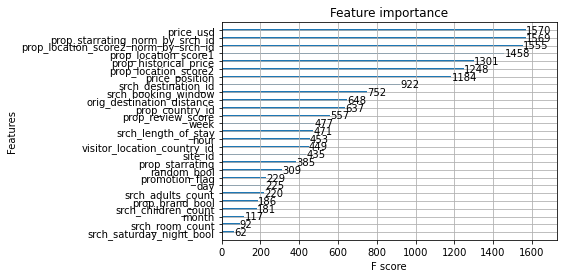

In [164]:
xgb.plot_importance(model)
#target_list = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2",
#              "price_usd", "srch_adults_count", "srch_children_count", "srch_room_count", "orig_destination_distance",
#              "month", "week", "day", "prop_historical_price", "price_position"]
#"prop_location_score1", "price_position","prop_historical_price"

In [165]:
# This could be done more efficiently

# Prepare output file
output = pd.DataFrame()
output["srch_id"] = testset["srch_id"]
output["prop_id"] = properties

# Add scores
pred_scores_list = []

for i in predictions:
    for j in i:
        pred_scores_list.append(j)      

output["pred_scores"] = pred_scores_list

In [166]:
out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)

In [167]:
del out["pred_scores"]

In [168]:
out.head()

srch_id  prop_id
srch_id                     
1       23        1    99484
        12        1    61934
        9         1    54937
        4         1    24194
        5         1    28181

In [169]:
out.to_csv('../data/submission_normalization4.csv', index=False)